<a href="https://colab.research.google.com/github/Junyoungs7/Colab_ML_DL_Python/blob/main/transfer_learning__VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tqdm

In [ ]:
import os
import urllib.request
import zipfile

data_dir = "/content/drive/MyDrive/ColabNotebooks/datas/datasets"
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIP 파일을 읽는다
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIP을 압축 해제
    zip.close()  # ZIP 파일을 닫는다

    # ZIP 파일을 삭제
    os.remove(save_path)

# 사전 준비

In [ ]:
# 패키지 import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataSet 작성

In [ ]:
# 입력 화상의 전처리 클래스
# 훈련시와 추론시 처리가 다름

"""
화상 전처리 클래스. 훈련시, 검증시의 동작이 다르다.
화상 크기를 리사이즈하고, 색상을 표준화한다.
훈련시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터를 확장한다.

Attributes
----------
resize : int
    리사이즈 대상 화상의 크기.
mean : (R, G, B)
    각 색상 채널의 평균 값.
std : (R, G, B)
    각 색상 채널의 표준 편차.
"""

class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.RandomResizedCrop(resize),
            transforms.RandomHorizontalFlip(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase='train'):
      """
      Parameters
      ----------
      phase : 'train' or 'val'
          전처리 모드를 지정.
      """
      return self.data_transform[phase](img)

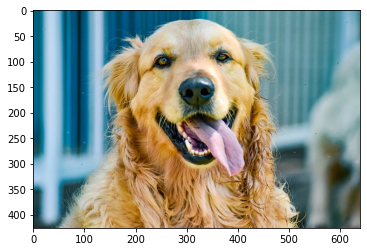

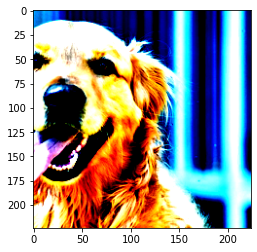

In [ ]:
# 훈련 동작 확인 => 실행마다 처리 결과 화상 바뀜

image_file_path = '/content/drive/MyDrive/ColabNotebooks/Pytorch_sorce/source/ex_source/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [ ]:
# 개미와 벌이 담긴 화상 파일의 경로 리스트 작성
def make_datapath_list(phase="train"):
  rootpath = "/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/"
  target_path = osp.join(rootpath+phase+'/**/*.jpg')
  print(target_path)
  path_list = []

  for path in glob.glob(target_path):
    path_list.append(path)

  return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/**/*.jpg
/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/val/**/*.jpg


['/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/0013035.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/116570827_e9c126745d.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 '/content/drive/MyDrive/ColabNotebooks/datas/datasets/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg',
 '/content/drive

In [ ]:
# 개미와 벌의 화상에 대한 Dataset 작성
class HymenopteraDataset(data.Dataset):
    """
    개미와 벌 화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지를 설정한다.
    """
    
    def __init__(self, file_list, transform=None, phase='train'):
      self.file_list = file_list
      self.transform = transform
      self.phase = phase

    def __len__(self):
      return len(self.file_list)

    def __getitem__(self, index):

      # index번째 화상 로드
      img_path = self.file_list[index]
      img = Image.open(img_path)
      
      #화상의 전처리 실시
      img_transformed = self.transform(img, self.phase)

      #화상 라벨을 파일 이름에서 추출
      if self.phase == "train":
        label = img_path[76:80]
      elif self.phase == "val":
        label = img_path[74:78]

      #라벨을 숫자로 변경
      if label == "ants":
        label = 0
      elif label == "bees":
        label = 1

      return img_transformed, label

# 실행
train_dataset = HymenopteraDataset(file_list = train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(file_list = val_list, transform=ImageTransform(size, mean, std), phase='val')

# 동작 확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


# DataLoader 작성

In [ ]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리 = 학습 및 검증 시 쉽게 다루기 위해서
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloader_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0])


# 네트워크 모델 작성

In [ ]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
net.train()
print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


# 손실 함수 정의

In [ ]:
criterion = nn.CrossEntropyLoss()

# 최적화 기법 설정

In [ ]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
  if name in update_param_names:
    param.requires_grad = True
    params_to_update.append(param)
    print(name)
  else:
    param.requires_grad = False

print("-----------")
print("param_to_update")

classifier.6.weight
classifier.6.bias
-----------
param_to_update


In [ ]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

# 학습 및 검증 실시

In [ ]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs):
  # epoch루프
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('--------------')

    # epoch별 학습 및 검증 루프
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      elif phase == 'val':
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      # 미 학습시 검증 성능 확인을 위해 epoch=0의 훈련 생략
      if (epoch == 0) and (phase == 'train'):
        continue

      # 데이터 로더로 미니 배치를 꺼내는 루프
      for inputs, labels in tqdm(dataloader_dict[phase]):
        optimizer.zero_grad()

        # 순전파 계산
        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          # 훈련시에는 오차 역전파
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # 반복 결과 계산
          # loss 합계 갱신
          epoch_loss += loss.item() * inputs.size(0)
          # 정답 수의 합계 갱신
          epoch_corrects += torch.sum(preds == labels.data)


      epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [ ]:
num_epochs=2
train_model(net, dataloader_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
--------------


100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


val Loss: 0.7011 Acc: 0.5033
Epoch 2/2
--------------


100%|██████████| 8/8 [02:16<00:00, 17.11s/it]


train Loss: 0.4963 Acc: 0.7284


100%|██████████| 5/5 [01:26<00:00, 17.30s/it]

val Loss: 0.1970 Acc: 0.9477
